In [ ]:
# Conexão com o Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Install necessary libraries
!pip install -q albumentations==1.0.3
!pip install -q torchvision==0.10.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 kB 10.2 MB/s eta 0:00:00
ERROR: Ignored the following yanked versions: 0.1.6, 0.1.7, 0.1.8, 0.1.9, 0.2.0, 0.2.1, 0.2.2, 0.2.2.post2, 0.2.2.post3, 0.15.0
ERROR: Could not find a version that satisfies the requirement torchvision==0.10.0 (from versions: 0.12.0, 0.13.0, 0.13.1, 0.14.0, 0.14.1, 0.15.1, 0.15.2, 0.16.0, 0.16.1, 0.16.2, 0.17.0, 0.17.1, 0.17.2, 0.18.0, 0.18.1, 0.19.0, 0.19.1)
ERROR: No matching distribution found for torchvision==0.10.0


In [ ]:
import os
import cv2
import xml.etree.ElementTree as ET
import torch
import torchvision
import random
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# Set the paths to your files
annotations_path = '/content/drive/MyDrive/approach_nwot/xml/annotations_deteccao.xml'
video_path = '/content/drive/MyDrive/approach_nwot/videos/video_colorido_concatenado_10fps.mp4'

# Parse the XML annotations
tree = ET.parse(annotations_path)
root = tree.getroot()

tracks = root.findall('track')

annotations_per_frame = {}

for track in tracks:
    label = track.get('label')
    for box in track.findall('box'):
        frame = int(box.get('frame'))
        outside = box.get('outside')
        if outside == '1':
            continue  # skip boxes with outside="1"
        xtl = float(box.get('xtl'))
        ytl = float(box.get('ytl'))
        xbr = float(box.get('xbr'))
        ybr = float(box.get('ybr'))
        bbox = [xtl, ytl, xbr, ybr]
        # Add to annotations_per_frame
        if frame not in annotations_per_frame:
            annotations_per_frame[frame] = []
        annotations_per_frame[frame].append({'label': label, 'bbox': bbox})

# Map labels to class IDs
label_to_id = {'cabeca': 1}

# Read frames from the video corresponding to the annotated frames
cap = cv2.VideoCapture(video_path)

frames_to_process = sorted(annotations_per_frame.keys())

images = []
targets = []

for frame_num in frames_to_process:
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_num)
    ret, frame = cap.read()
    if not ret:
        print(f"Failed to read frame {frame_num}")
        continue
    # Convert frame from BGR to RGB
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    annotations = annotations_per_frame[frame_num]
    boxes = []
    labels = []
    for annotation in annotations:
        bbox = annotation['bbox']
        label = annotation['label']
        boxes.append(bbox)
        labels.append(label_to_id[label])
    # Convert to tensors
    boxes = torch.as_tensor(boxes, dtype=torch.float32)
    labels = torch.as_tensor(labels, dtype=torch.int64)
    image_id = torch.tensor([frame_num])
    area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
    iscrowd = torch.zeros((len(labels),), dtype=torch.int64)
    target = {}
    target['boxes'] = boxes
    target['labels'] = labels
    target['image_id'] = image_id
    target['area'] = area
    target['iscrowd'] = iscrowd
    # Append to lists
    images.append(frame)
    targets.append(target)

# Define data augmentation using Albumentations
transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.RandomRotate90(p=0.5),
    A.MotionBlur(p=0.2),
    A.ColorJitter(p=0.2),
    ToTensorV2()
],
    bbox_params=A.BboxParams(format='pascal_voc', label_fields=['category_ids'])
)

# Apply data augmentation
augmented_images = []
augmented_targets = []
num_augmentations = 5

for i in range(len(images)):
    image = images[i]
    target = targets[i]
    for _ in range(num_augmentations):
        # Prepare data for Albumentations
        bboxes = target['boxes'].numpy()
        # Albumentations expects labels as a list
        category_ids = target['labels'].numpy().tolist()
        # Apply the transformations
        augmented = transform(image=image, bboxes=bboxes, category_ids=category_ids)
        aug_image = augmented['image']
        aug_bboxes = augmented['bboxes']
        aug_labels = augmented['category_ids']
        # Convert back to tensors
        aug_image = aug_image
        if len(aug_bboxes) == 0:
            continue  # Skip if no bounding boxes after augmentation
        aug_bboxes = torch.as_tensor(aug_bboxes, dtype=torch.float32)
        aug_labels = torch.as_tensor(aug_labels, dtype=torch.int64)
        image_id = target['image_id']
        area = (aug_bboxes[:, 3] - aug_bboxes[:, 1]) * (aug_bboxes[:, 2] - aug_bboxes[:, 0])
        iscrowd = torch.zeros((len(aug_labels),), dtype=torch.int64)
        aug_target = {}
        aug_target['boxes'] = aug_bboxes
        aug_target['labels'] = aug_labels
        aug_target['image_id'] = image_id
        aug_target['area'] = area
        aug_target['iscrowd'] = iscrowd
        augmented_images.append(aug_image)
        augmented_targets.append(aug_target)

# Combine original and augmented data
all_images = [ToTensorV2()(image=image)['image'] for image in images] + augmented_images
all_targets = targets + augmented_targets

# Define the custom dataset
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, images, targets):
        self.images = images
        self.targets = targets

    def __getitem__(self, idx):
        return self.images[idx], self.targets[idx]

    def __len__(self):
        return len(self.images)

dataset = CustomDataset(all_images, all_targets)

# Split the dataset into training and validation sets
from sklearn.model_selection import train_test_split

indices = list(range(len(dataset)))
train_indices, val_indices = train_test_split(indices, test_size=0.2, random_state=42)

train_dataset = torch.utils.data.Subset(dataset, train_indices)
val_dataset = torch.utils.data.Subset(dataset, val_indices)

# Define collate_fn for DataLoader
def collate_fn(batch):
    return tuple(zip(*batch))

# Create data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=2, shuffle=True, collate_fn=collate_fn)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=1, shuffle=False, collate_fn=collate_fn)

# Define the model (Faster R-CNN)
num_classes = 2  # 1 class ('cabeca') + background

model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

# Replace the classifier with a new one
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# Move the model to the device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

# Define the optimizer and learning rate scheduler
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:00<00:00, 217MB/s]


In [ ]:
# Training loop
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    i = 0
    for images_batch, targets_batch in train_loader:
        # Converter as imagens para float e normalizá-las
        images_batch = list(image.to(device).float() / 255.0 for image in images_batch)
        targets_batch = [{k: v.to(device) for k, v in t.items()} for t in targets_batch]
        loss_dict = model(images_batch, targets_batch)
        losses = sum(loss for loss in loss_dict.values())
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        i += 1
        if i % 10 == 0:
            print(f"Epoch {epoch+1}, Iteration {i}, Loss: {losses.item():.4f}")
    lr_scheduler.step()
    print(f"Epoch {epoch+1} completed.")


Epoch 1, Iteration 10, Loss: 0.3752
Epoch 1, Iteration 20, Loss: 0.4862
Epoch 1, Iteration 30, Loss: 0.2470
Epoch 1, Iteration 40, Loss: 0.1524
Epoch 1, Iteration 50, Loss: 0.1906
Epoch 1, Iteration 60, Loss: 0.2303
Epoch 1, Iteration 70, Loss: 0.3754
Epoch 1, Iteration 80, Loss: 0.1847
Epoch 1, Iteration 90, Loss: 0.1975
Epoch 1, Iteration 100, Loss: 0.1225
Epoch 1, Iteration 110, Loss: 0.2609
Epoch 1, Iteration 120, Loss: 0.0895
Epoch 1, Iteration 130, Loss: 0.1300
Epoch 1, Iteration 140, Loss: 0.1584
Epoch 1, Iteration 150, Loss: 0.0797
Epoch 1, Iteration 160, Loss: 0.1838
Epoch 1, Iteration 170, Loss: 0.1749
Epoch 1, Iteration 180, Loss: 0.1848
Epoch 1, Iteration 190, Loss: 0.1174
Epoch 1, Iteration 200, Loss: 0.2000
Epoch 1, Iteration 210, Loss: 0.1800
Epoch 1, Iteration 220, Loss: 0.0831
Epoch 1, Iteration 230, Loss: 0.1574
Epoch 1, Iteration 240, Loss: 0.1298
Epoch 1, Iteration 250, Loss: 0.1868
Epoch 1 completed.
Epoch 2, Iteration 10, Loss: 0.1185
Epoch 2, Iteration 20, Loss: 

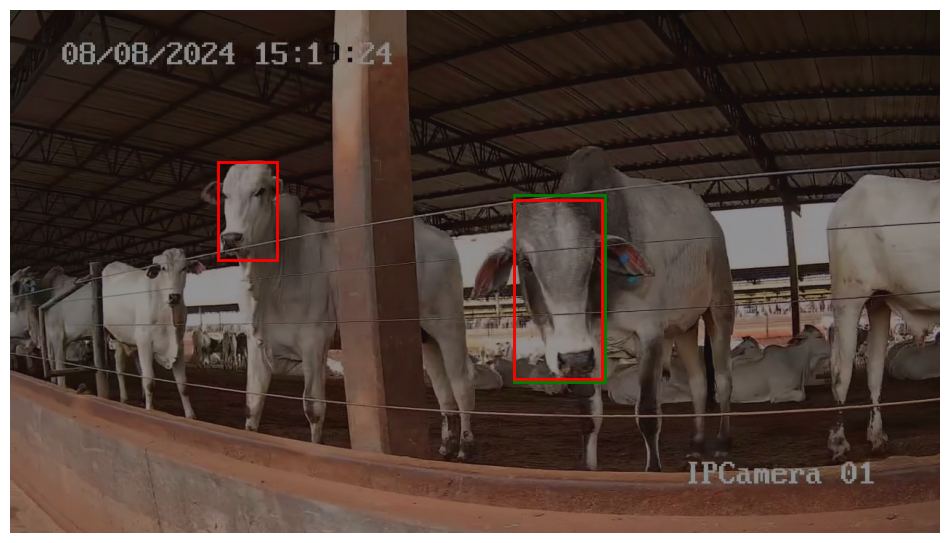

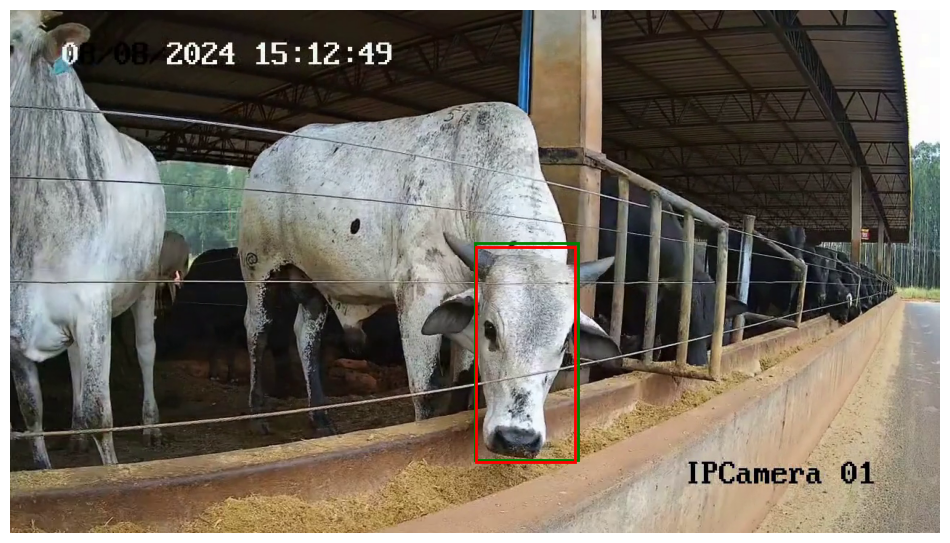

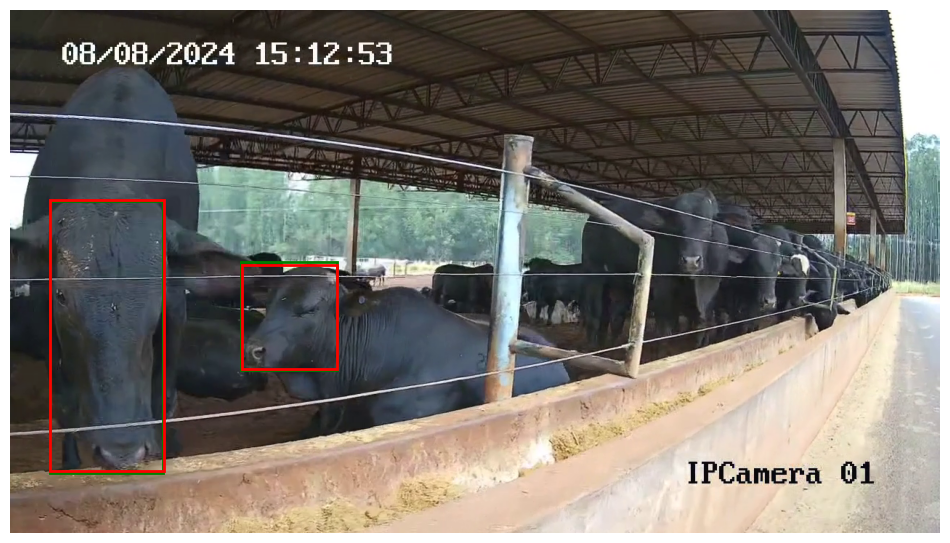

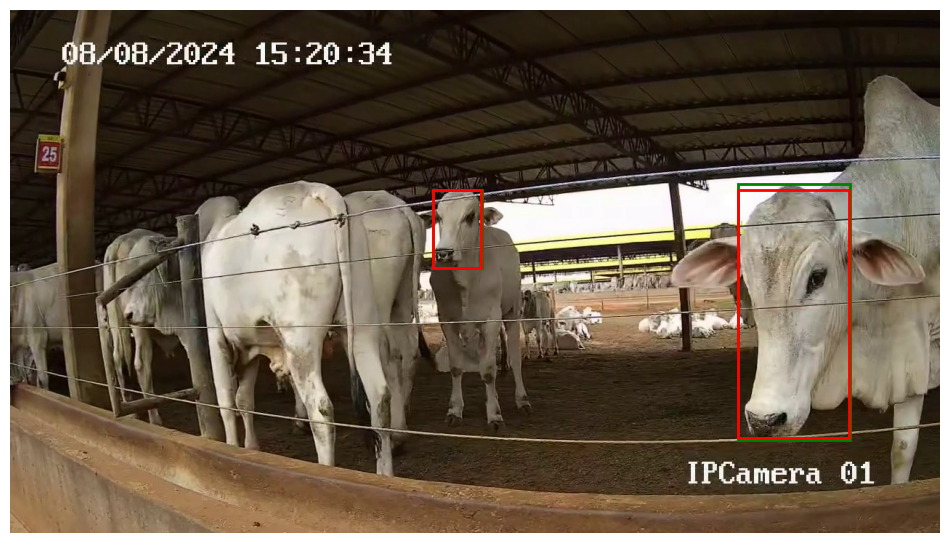

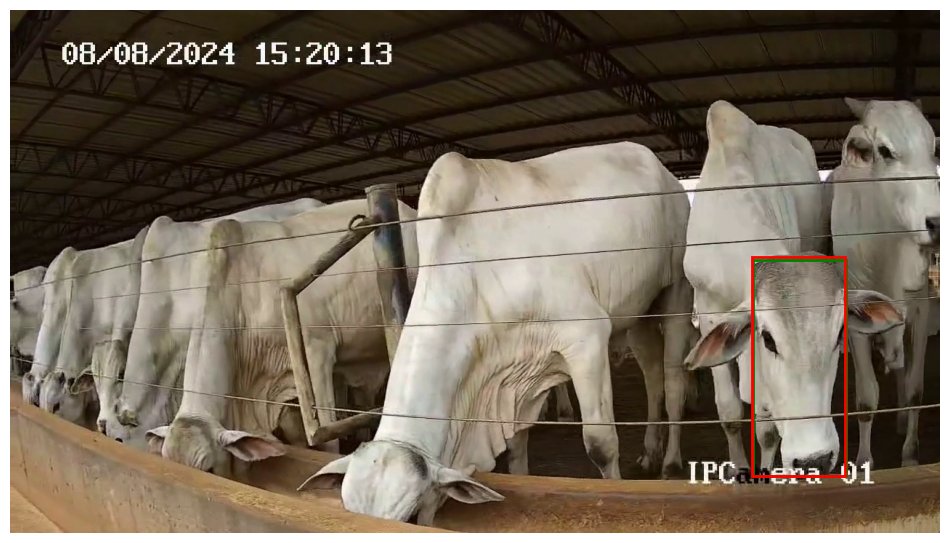

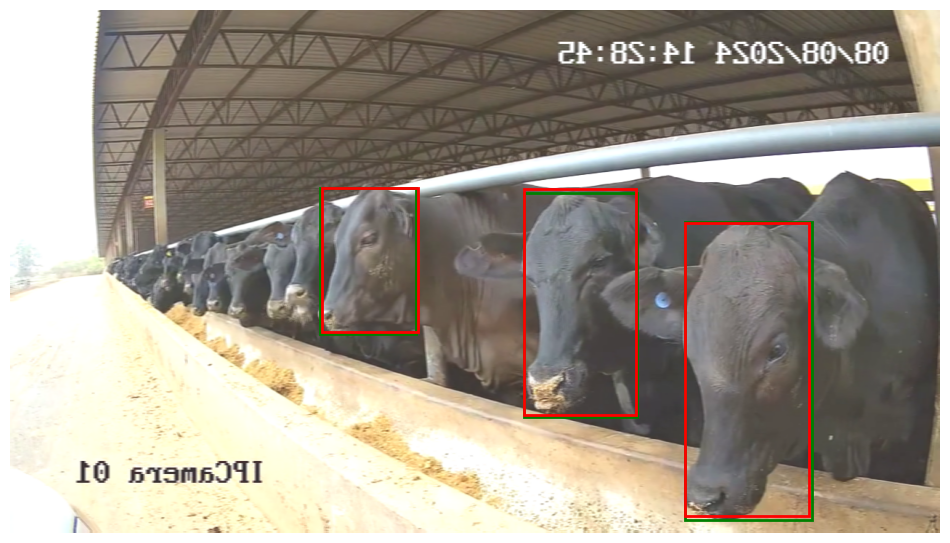

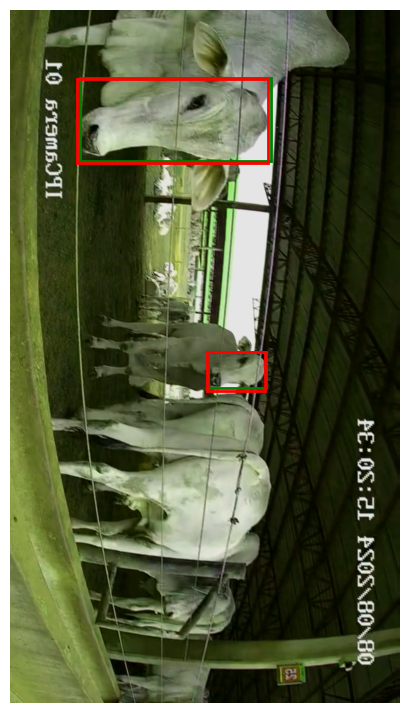

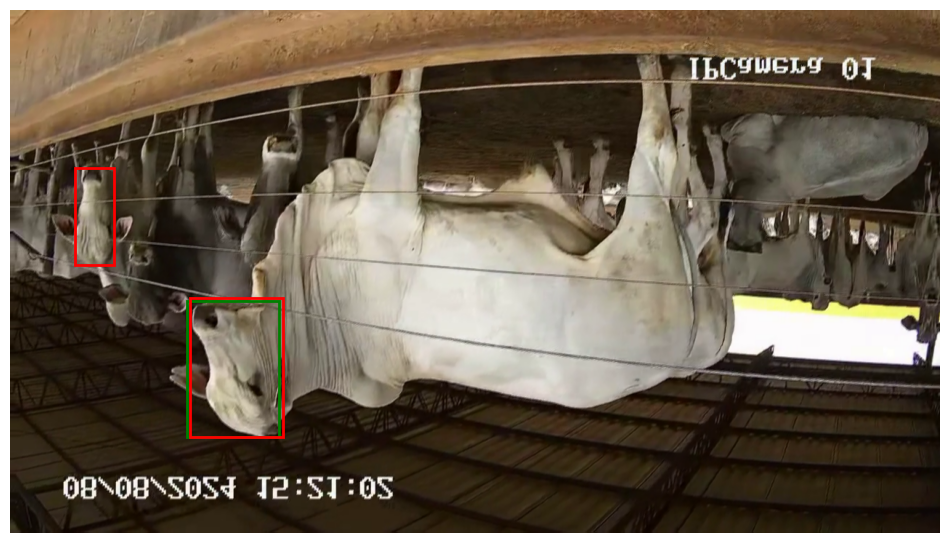

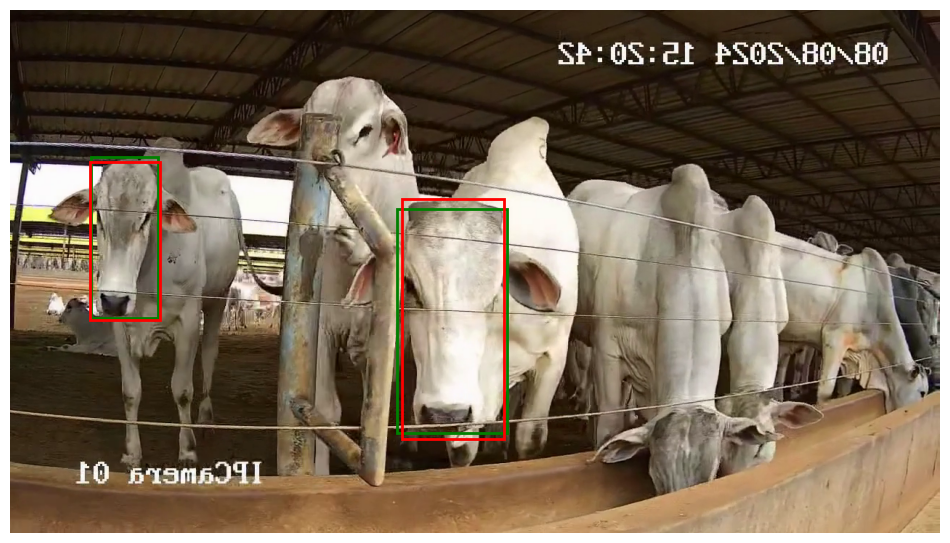

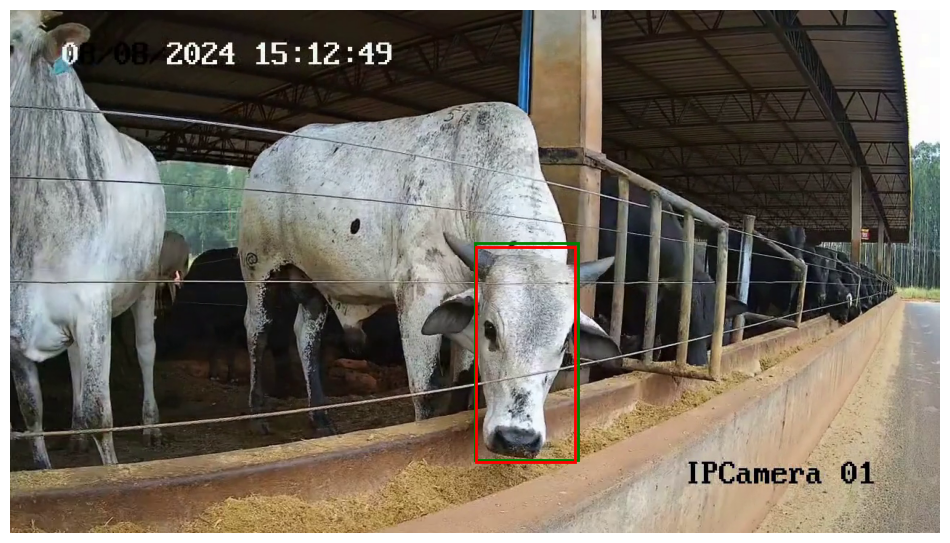

In [ ]:
# Visualization of results
model.eval()
import random

num_images_to_show = 40
for idx in random.sample(range(len(val_dataset)), num_images_to_show):
    img, target = val_dataset[idx]
    # img is a tensor, move to device
    img = img.to(device).float() / 255.0  # Converte para float32 e normaliza
    # Run the model
    with torch.no_grad():
        prediction = model([img])
    # Convert image to CPU and numpy
    img_np = img.cpu().numpy()
    img_np = np.transpose(img_np, (1, 2, 0))
    img_np = (img_np * 255).astype(np.uint8)
    # Plot the image
    fig, ax = plt.subplots(1, figsize=(12, 9))
    ax.imshow(img_np)
    # Plot ground truth boxes in green
    boxes = target['boxes'].cpu().numpy()
    for box in boxes:
        rect = plt.Rectangle((box[0], box[1]), box[2]-box[0], box[3]-box[1],
                             linewidth=2, edgecolor='g', facecolor='none')
        ax.add_patch(rect)
    # Plot predicted boxes in red
    pred_boxes = prediction[0]['boxes'].cpu().numpy()
    pred_scores = prediction[0]['scores'].cpu().numpy()
    # Only plot boxes with score above a threshold
    threshold = 0.5
    for box, score in zip(pred_boxes, pred_scores):
        if score > threshold:
            rect = plt.Rectangle((box[0], box[1]), box[2]-box[0], box[3]-box[1],
                                 linewidth=2, edgecolor='r', facecolor='none')
            ax.add_patch(rect)
    plt.axis('off')
    plt.show()
